This notebook provides Python scripts to import, compile, modify, graph, and export Solinst transducer data. 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import glob
import re
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as tick
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.tsa.tsatools as tools
from pandas.stats.api import ols
from datetime import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [2]:
import sys
sys.path.append(r'C:\Users\PAULINKENBRANDT\Documents\GitHub\Snake_Valley\data_import')
import Snake_Valley_Data_Import as svdi

SyntaxError: invalid syntax (Snake_Valley_Data_Import.py, line 1)

# Setting Up the Solinst Barologger and Levelogger

I always set my transducers to `future start` to make the tranducer start on the hour.  I also allow the Levelogger to take an instantaneous measurement out of water, and zero the transducer out to accomodate for elevation.

# Import Relevant Files

First, we must import all of the relevant data. To properly import transducer data, we need:
* Transducer (Levelogger) data
* Barometric (Barologger) data
* Manual Depth to Water Measurements
    
If we want to calculate water-level elevation, we also need:
* Well stickup length (ground to measure point distance)
* Ground surface elevation at well
<br/>OR<br/>
* Elevation of measure point

In [10]:
def getfilename(path):
    '''
    this function extracts the file name without file path or extension
    '''
    return path.split('\\').pop().split('/').pop().rsplit('.', 1)[0]

In [33]:
def new_xle_imp(infile):
    '''
    This function uses an exact file path to upload a Solinst xle file. 
    
    infile = complete file path to input file
    
    RETURNS
    A pandas dataframe containing the transducer data
    '''
    # open text file
    with open(infile) as fd:
        # parse xml
        obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
    # navigate through xml to the data
    wellrawdata = obj['Body_xle']['Data']['Log']
    # convert xml data to pandas dataframe
    f = pd.DataFrame(wellrawdata)
    # get header names and apply to the pandas dataframe
    f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2']
    
    tempunit = (obj['Body_xle']['Ch2_data_header']['Unit'])
    if tempunit == 'Deg C' or tempunit == u'\N{DEGREE SIGN}' + u'C':
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2'].convert_objects(convert_numeric=True)
    elif tempunit == 'Deg F' or tempunit == u'\N{DEGREE SIGN}' + u'F': 
        f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f['ch2'].convert_objects(convert_numeric=True)*0.33456

    
    unit = str(obj['Body_xle']['Ch1_data_header']['Unit']).lower()
    if unit == "feet" or unit == "ft":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1'].convert_objects(convert_numeric=True)
    elif unit == "kpa":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1'].convert_objects(convert_numeric=True)*0.33456
    elif unit == "mbar":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1'].convert_objects(convert_numeric=True)*0.0334552565551
    elif unit == "psi":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1'].convert_objects(convert_numeric=True)*2.306726
    elif unit == "m" or unit == "meters":
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1'].convert_objects(convert_numeric=True)*3.28084
    else:
        f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f['ch1'].convert_objects(convert_numeric=True)
        print "Unknown Units"
    # add extension-free file name to dataframe
    f['name'] = getfilename(infile)
    # combine Date and Time fields into one field
    f['DateTime'] = pd.to_datetime(f.apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
    f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f[str(obj['Body_xle']['Ch1_data_header']['Identification']).title()].convert_objects(convert_numeric=True)
    f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f[str(obj['Body_xle']['Ch2_data_header']['Identification']).title()].convert_objects(convert_numeric=True)
    f = f.reset_index()
    f = f.set_index('DateTime')
    f = f.drop(['Date','Time','@id','ch1','ch2','index','ms'],axis=1)
    return f

In [41]:
#testfile = r'U:\GWP\Groundwater\Courthouse_Wash_Transducer_Data\chwnav 2015_06_12.xle'
testfile = r'U:\GWP\Groundwater\Courthouse_Wash_Transducer_Data\chwent 2015_06_12.xle'
f = new_xle_imp(testfile)
f = snake.hourly_resample(f,57)

NameError: name 'snake' is not defined

In [46]:
barofile = new_xle_imp("E:\\UMAR\\Phase_II\\Data\\RAW\\baro_2015-04-01.xle")
barofile2 = pd.read_csv("E:\UMAR\Phase_II\Data\RAW\UCC.csv",parse_dates=True,index_col='Day',skiprows=14, na_values=['M','S'])
wellfile = new_xle_imp("E:\\UMAR\\Phase_II\\Data\\RAW\\arnold_well_2015-04-01.xle")
manualfile = pd.read_excel("E:\\UMAR\\Phase_II\\Data\\Manual_Readings.xlsx","Arn_Well",index_col="datetime")

In [36]:
wellfile_prov = new_xle_imp("E:\\UMAR\\Phase_II\\Data\\RAW\\PROVIDENCE CREEK_2015_01_21.xle")
prov_crk_man = pd.read_excel("E:\\UMAR\\Phase_II\\Data\\Manual_Readings.xlsx","Prov_Creek",index_col="datetime")

In [5]:
barofile2['ft_water_bp']= barofile2['Sea Level Pressure']*0.0335 - (31.17 - 4806/826 + 7.8) # convert hPa to ft water
barofile2 = barofile2.interpolate(method='time') # fill NA spots


## Compile Files if Necessary

You can search through a directory and append several files together into a single dataframe.

In [6]:
def compilation(inputfile):
    """
    This function reads multiple Solinst transducer files in a directory and generates a compiled Pandas dataframe.
    
    inputfile = complete file path to input files; use * for wildcard in file name
        example -> 'O:\\Snake Valley Water\\Transducer Data\\Raw_data_archive\\all\\LEV\\*baro*' picks any file containing 'baro'
    
    packages required:
        pandas as pd
        glob
        os
        xmltodict
    """
        
    # create empty dictionary to hold dataframes
    f={}

    # generate list of relevant files
    filelist = glob.glob(inputfile)

    # iterate through list of relevant files
    for infile in filelist:
        # get the extension of the input file
        filetype = os.path.splitext(infile)[1]
        # run computations using lev files
        if filetype=='.lev':
            # open text file
            with open(infile) as fd:
                # find beginning of data
                indices = fd.readlines().index('[Data]\n')

            # convert data to pandas dataframe starting at the indexed data line
            f[getfilename(infile)] = pd.read_table(infile, parse_dates=True, sep='     ', index_col=0,
                                           skiprows=indices+2, names=['DateTime','Level','Temperature'], skipfooter=1,engine='python')
            # add extension-free file name to dataframe
            f[getfilename(infile)]['name'] = getfilename(infile)
            
        # run computations using xle files
        elif filetype=='.xle':
            # open text file
            with open(infile) as fd:
                # parse xml
                obj = xmltodict.parse(fd.read(),encoding="ISO-8859-1")
            # navigate through xml to the data
            wellrawdata = obj['Body_xle']['Data']['Log']
            # convert xml data to pandas dataframe
            f[getfilename(infile)] = pd.DataFrame(wellrawdata)
            # get header names and apply to the pandas dataframe          
            f[getfilename(infile)][str(obj['Body_xle']['Ch1_data_header']['Identification']).title()] = f[getfilename(infile)]['ch1']
            f[getfilename(infile)][str(obj['Body_xle']['Ch2_data_header']['Identification']).title()] = f[getfilename(infile)]['ch2']
  
            # add extension-free file name to dataframe
            f[getfilename(infile)]['name'] = getfilename(infile)
            # combine Date and Time fields into one field
            f[getfilename(infile)]['DateTime'] = pd.to_datetime(f[getfilename(infile)].apply(lambda x: x['Date'] + ' ' + x['Time'], 1))
            f[getfilename(infile)] = f[getfilename(infile)].reset_index()
            f[getfilename(infile)] = f[getfilename(infile)].set_index('DateTime')
            f[getfilename(infile)] = f[getfilename(infile)].drop(['Date','Time','@id','ch1','ch2','index','ms'],axis=1)
        # run computations using csv files

        else:
            pass
    # concatonate all of the dataframes in dictionary f to one dataframe: g
    g = pd.concat(f)
    # remove multiindex and replace with index=Datetime
    g = g.reset_index()
    g = g.set_index(['DateTime'])
    # drop old indexes
    g = g.drop(['level_0'],axis=1)
    # remove duplicates based on index then sort by index
    g['ind']=g.index
    g.drop_duplicates(subset='ind',inplace=True)
    g.drop('ind',axis=1,inplace=True)
    g = g.sort()
    # ensure that the Level and Temperature data are in a float format
    g['Level'] = g['Level'].convert_objects(convert_numeric=True)
    g['Temperature'] = g['Temperature'].convert_objects(convert_numeric=True)
    outfile = g
    return outfile

## Graph Raw Data

You should always graph raw data to see if there are any tares in the data from users moving the tranducer placement.  Sometimes, the transducer is out of the water when it takes a measurement.  These points should be removed or adjusted.

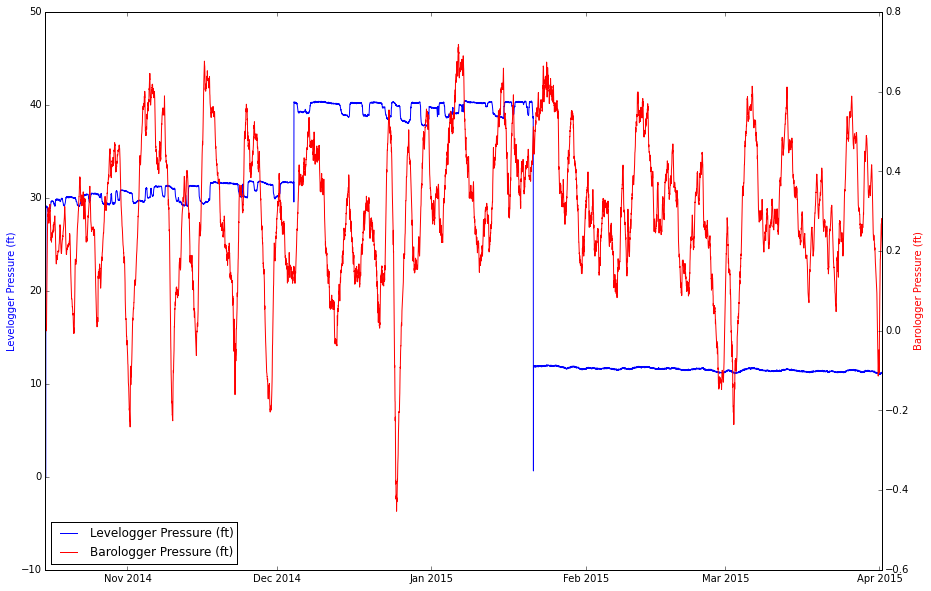

In [7]:
x1 = wellfile.index.to_datetime() #converts pandas dataframe index into datetime format for graph
x2 = barofile.index.to_datetime()

y1 = wellfile['Level']
y2 = barofile['Level']

fig, ax1 = plt.subplots()
ax1.plot(x1,y1,color='blue',label='Levelogger Pressure (ft)') # assumes units of ft
ax1.set_ylabel('Levelogger Pressure (ft)',color='blue')
y_formatter = tick.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)
ax2 = ax1.twinx()
ax2.set_ylabel('Barologger Pressure (ft)', color='red') 
ax2.plot(x2,y2,color='red',label='Barologger Pressure (ft)') # assumes units of ft
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)


This tranducer has a jump in the middle of the data caused by adjustments during manual recordings, as well as a jump at the beginning due to the transducer being out of water at the time of measurement.

In [8]:
def smoother(df, p, win=30, sd=3):
    '''
    remove outliers from a pandas dataframe column and fill with interpolated values
    warning: this will fill all NaN values in the dataframe with the interpolate function
    
    INPUT
    ------
    df= dataframe of interest
    p= column in dataframe with outliers
    win= size of window
    std= number of standard deviations allowed
    
    RETURNS
    ------
    Pandas dataframe with outliers removed
    '''
    df1 = df
    df1.loc[:,'dp'+ p] = df1[p].diff()
    df1.loc[:,'ma'+ p] = pd.rolling_mean(df1['dp'+ p], window=win, center=True)
    df1.loc[:,'mst'+p] = pd.rolling_std(df1['dp'+ p], window=win, center=True)
    for i in df.index:
        try:
            if abs(df1['dp'+ p][i] - df1['ma'+ p][i]) >= abs(df1['mst'+p][i]*sd):
                df.ix[i,p]=np.nan
            else:
                df.ix[i,p]=df[p][i]
        except (ValueError):
            try:
                if abs(df1['dp'+ p][i] - df1['ma'+ p][i]) >= abs(df1['dp'+p].std()*sd):
                    df.ix[i,p]=np.nan
                else:
                    df.ix[i,p]=df[p][i]
            except (ValueError):
                df.ix[i,p]=df[p][i]

    try:
        df1 = df1.drop(['dp'+p,'ma'+p,'mst'+p],axis=1)
    except(NameError,ValueError):
        pass            
    del df1
    try:
        df = df.drop(['dp'+p,'ma'+p,'mst'+p],axis=1)
    except(NameError,ValueError):
        pass  
    df = df.interpolate(method='time')
    df = df[1:-1]
    return df

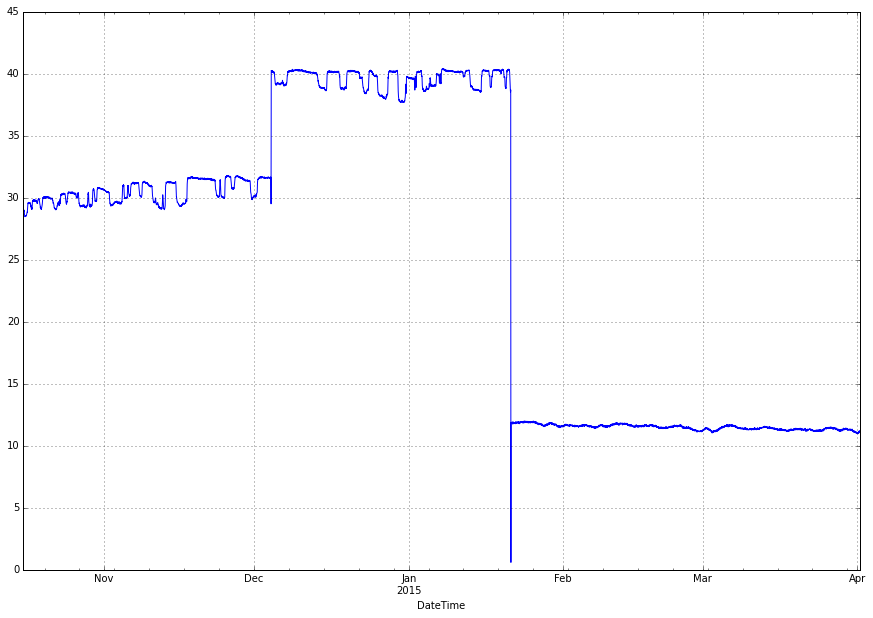

In [9]:
wellf = smoother(wellfile, 'Level', 30, 3)
wellf['Level'].plot()

# Remove Barometric Pressure

Solinst transducers are nonvented, meaning that they measure absolute pressure.  When they are submerged in a well, they are measuring the pressure of the water and the atmosphere.  In most cases, we are only interested in the pressure that the water exerts, so we have to subtract the pressure that the atmosphere is exerting.

## Match Measurement Interval of Barometer (Barologger) and Transducer  

It is best to set Solinst transducers (Leveloggers) to start at the same time and to measure at the same frequency as your Barologger. Sometimes, this does not happen.  To solve mismatches in sampling interval, we can resample the barometer data to same base (start time) and frequency as the transducer.

In [10]:
def hourly_resample(df,bse=0,minutes=60):
    '''
    INPUT
    -----
    df = pandas dataframe containing time series needing resampling
    bse = base time to set; default is zero (on the hour); 
    minutes = sampling recurrance interval in minutes; default is 60 (hourly samples)
    
    RETURNS
    -----
    A pandas dataframe that has been resampled to every hour, at the minute defined by the base (bse)
    
    DESCRIPTION
    -----
    see http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.resample.html for more info
    
    This function uses pandas powerful time-series manipulation to upsample to every minute, then downsample to every hour, 
    on the hour.
    
    This function will need adjustment if you do not want it to return hourly samples, or if you are sampling more frequently than
    once per minute.
    
    see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    '''
    df = df.resample('1Min') #you can make this smaller to accomodate for a higher sampling frequency
    df = df.interpolate(method='time') #http://pandas.pydata.org/pandas-docs/dev/generated/pandas.Series.interpolate.html
    df = df.resample(str(minutes)+'Min', how='first',closed='left',label='left', base=bse) #modify '60Min' to change the resulting frequency
    return df

Using the `hourly_resample` function above, we can resample each transducer dataset.

In [40]:
baro = hourly_resample(barofile,0,30)
well = hourly_resample(wellfile,0,30)
# reassign `Level` to reduce ambiguity
well['abs_feet_above_levelogger'] = well['Level']
baro['abs_feet_above_barologger'] = baro['Level']

Now that the data have a standard sampling interval, we can combine them into a single dataframe, which makes graphing and calculations easier.  The `merge` function in pandas has the added luxury of aligning the data to the same time and removing data that do not align.  If you want to keep the misaligned data, set the `how` to `'outer'`.

In [41]:
# combine baro and well data for easy calculations, graphing, and manipulation
wellbaro = pd.merge(well,baro,left_index=True,right_index=True,how='inner')

## Subtract Barometric Pressure from Absolute Transducer Pressure

Next we remove barometric pressure and match the data to manual readings.

In [42]:
wellbaro['adjusted_levelogger'] =  wellbaro['abs_feet_above_levelogger'] - wellbaro['abs_feet_above_barologger']

In [43]:
wellbaro.columns

Index([u'ch3', u'Temperature_x', u'Level_x', u'name_x', u'abs_feet_above_levelogger', u'Temperature_y', u'Level_y', u'name_y', u'abs_feet_above_barologger', u'adjusted_levelogger'], dtype='object')

In [44]:
wellbaro

,ch3,Temperature_x,Level_x,name_x,abs_feet_above_levelogger,Temperature_y,Level_y,name_y,abs_feet_above_barologger,adjusted_levelogger
DateTime,,,,,,,,,,
2014-10-15 14:30:00,0.000,23.2,-0.039,arnold_well_2015-04-01,-0.039,18.004,0.0132,baro_2015-04-01,0.0132,-0.0522
2014-10-15 15:00:00,0.389,11.5,28.681,arnold_well_2015-04-01,28.681,18.208,0.0134,baro_2015-04-01,0.0134,28.6676
2014-10-15 15:30:00,0.391,11.5,28.996,arnold_well_2015-04-01,28.996,18.379,0.0113,baro_2015-04-01,0.0113,28.9847
2014-10-15 16:00:00,0.391,11.5,29.094,arnold_well_2015-04-01,29.094,18.524,0.0121,baro_2015-04-01,0.0121,29.0819
2014-10-15 16:30:00,0.392,11.5,29.134,arnold_well_2015-04-01,29.134,18.724,0.0098,baro_2015-04-01,0.0098,29.1242
2014-10-15 17:00:00,0.392,11.5,29.055,arnold_well_2015-04-01,29.055,18.864,0.0033,baro_2015-04-01,0.0033,29.0517
2014-10-15 17:30:00,0.392,11.5,29.055,arnold_well_2015-04-01,29.055,18.932,-0.0005,baro_2015-04-01,-0.0005,29.0555
2014-10-15 18:00:00,0.392,11.5,29.075,arnold_well_2015-04-01,29.075,18.937,0.0075,baro_2015-04-01,0.0075,29.0675
2014-10-15 18:30:00,0.391,11.5,29.075,arnold_well_2015-04-01,29.075,18.351,0.0612,baro_2015-04-01,0.0612,29.0138


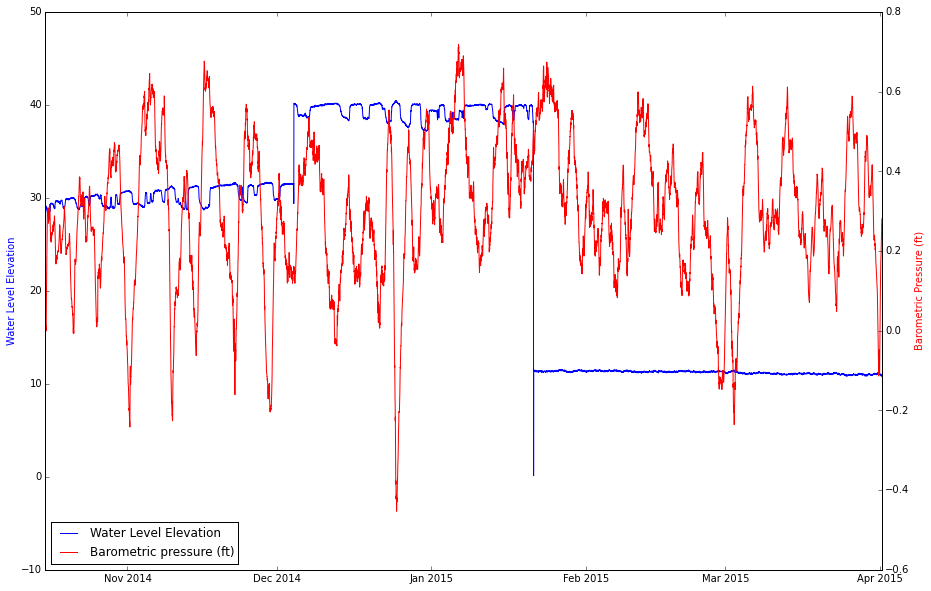

In [45]:
x1 = wellbaro.index.to_datetime()
x2 = wellbaro.index.to_datetime()
y1 = wellbaro['adjusted_levelogger'].values
y2 = wellbaro['abs_feet_above_barologger'].values

fig, ax1 = plt.subplots()

ax1.plot(x1,y1,color='blue',label='Water Level Elevation')
ax1.set_ylabel('Water Level Elevation',color='blue')
y_formatter = tick.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)
ax2 = ax1.twinx()
ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
ax2.plot(x2,y2,color='red',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

# Match Measurements to Manual Readings

We can use the following tool to find the closest matching indexes to our manual measurements. Once we match indexes up, we can calibrate the transducer readings to our manual depth to water measurements.

In [16]:
def fcl(df, dtObj):
    '''
    finds closest date index in a dataframe to a date object
    
    df = dataframe
    dtObj = date object
    
    taken from: http://stackoverflow.com/questions/15115547/find-closest-row-of-dataframe-to-given-time-in-pandas
    '''
    return df.iloc[np.argmin(np.abs(df.index.to_pydatetime() - dtObj))]

In [17]:
print manualfile

                     dtw_ft                             comment  aw_spc_uS  \
datetime                                                                     
2014-10-15 13:35:00  310.71  wl from casing top; bailer samples        553   
2014-12-04 09:00:00  309.91  wl from casing top; bailer samples        537   
2015-01-21 11:30:00  310.07  wl from casing top; bailer samples        492   
2015-04-01 11:58:00  310.53  wl from casing top; bailer samples        494   
2015-04-01 13:02:00  310.50  wl from casing top; bailer samples        NaN   

                     aw_T_C  aw_pH  aw_DO_mgL  aw_ORP_mV  
datetime                                                  
2014-10-15 13:35:00     9.8   7.74       8.51        NaN  
2014-12-04 09:00:00    10.9   7.95        NaN        NaN  
2015-01-21 11:30:00    11.7   7.94        NaN        316  
2015-04-01 11:58:00    11.7   7.33        NaN        362  
2015-04-01 13:02:00     NaN    NaN        NaN        NaN  


In [50]:
def baro_drift_correct(wellfile,barofile,manualfile,sampint=60,wellelev=4800,stickup=0):
    '''
    INPUT
    -----
    wellfile = pandas dataframe with water level data labeled 'Level'; index must be datetime
    barofile = pandas dataframe with barometric data labeled 'Level'; index must be datetime
    manualfile = pandas dataframe with manual level data in the first column after the index; index must be datetime
    
    sampint = sampling interval in minutes; default 60
    wellelev = site ground surface elevation in feet
    stickup = offset of measure point from ground in feet
    
    OUTPUT
    -----
    wellbarofinal = pandas dataframe with corrected water levels 
    
    This function uses pandas dataframes created using the 

    '''
    # resample data to make sample interval consistent
    baro = hourly_resample(barofile,0,sampint)
    well = hourly_resample(wellfile,0,sampint)
    # reassign `Level` to reduce ambiguity
    well['abs_feet_above_levelogger'] = well['Level']
    baro['abs_feet_above_barologger'] = baro['Level']
    # combine baro and well data for easy calculations, graphing, and manipulation
    wellbaro = pd.merge(well,baro,left_index=True,right_index=True,how='inner')
    wellbaro['adjusted_levelogger'] =  wellbaro['abs_feet_above_levelogger'] - wellbaro['abs_feet_above_barologger']
    
    breakpoints = []
    bracketedwls = {}

    for i in range(len(manualfile)+1):
        breakpoints.append(fcl(wellbaro, manualfile.index.to_datetime()[i-1]).name)

    last_man_wl,first_man_wl,last_tran_wl,driftlen = [],[],[],[]

    firstupper, firstlower, firstlev, lastupper, lastlower, lastlev = [],[],[],[],[],[]

    for i in range(len(manualfile)-1):
        # Break up time series into pieces based on timing of manual measurements
        bracketedwls[i+1] = wellbaro.loc[(wellbaro.index.to_datetime() > breakpoints[i+1])&(wellbaro.index.to_datetime() < breakpoints[i+2])]
        bracketedwls[i+1]['diff_wls'] = bracketedwls[i+1]['abs_feet_above_levelogger'].diff() 
        firstupper.append(np.mean(bracketedwls[i+1]['diff_wls'][2:41]) + 
                          np.std(bracketedwls[i+1]['diff_wls'][2:41])*2.0) # 2.2 std dev.
        firstlower.append(np.mean(bracketedwls[i+1]['diff_wls'][2:41]) - 
                          np.std(bracketedwls[i+1]['diff_wls'][2:41])*2.0) # 2.2 std dev.
        firstlev.append(bracketedwls[i+1].ix[1,'diff_wls']) # difference of first two values
        ## Examine Last Value
        lastupper.append(np.mean(bracketedwls[i+1]['diff_wls'][-41:-2]) + 
                         np.std(bracketedwls[i+1]['diff_wls'][-41:-2])*2.0) # 2.2 std dev.
        lastlower.append(np.mean(bracketedwls[i+1]['diff_wls'][-41:-2]) - 
                         np.std(bracketedwls[i+1]['diff_wls'][-41:-2])*2.0) # 2.2 std dev.
        lastlev.append(bracketedwls[i+1].ix[-1,'diff_wls']) # difference of last two values
        ## drop first value if 2.2 std dev beyond first 30 values
        if np.abs(firstlev[i]) > 0.1:
            if firstlev[i] > firstupper[i] or firstlev[i] < firstlower[i]:
                bracketedwls[i+1].drop(bracketedwls[i+1].index[0],inplace=True)
        ## drop last value if 2.2 std dev beyond last 30 values
        if np.abs(lastlev[i]) > 0.1:
            if lastlev[i] > lastupper[i] or lastlev[i] < lastlower[i]:
                bracketedwls[i+1].drop(bracketedwls[i+1].index[-1],inplace=True)

        bracketedwls[i+1].loc[:,'DeltaLevel'] = bracketedwls[i+1].loc[:,'adjusted_levelogger'] - bracketedwls[i+1].ix[0,'adjusted_levelogger']
        bracketedwls[i+1].loc[:,'MeasuredDTW'] = fcl(manualfile,breakpoints[i+1])[0] - bracketedwls[i+1].loc[:,'DeltaLevel']

        last_man_wl.append(fcl(manualfile,breakpoints[i+2])[0])
        first_man_wl.append(fcl(manualfile,breakpoints[i+1])[0])
        last_tran_wl.append(float(bracketedwls[i+1].loc[max(bracketedwls[i+1].index.to_datetime()),'MeasuredDTW']))
        driftlen.append(len(bracketedwls[i+1].index))
        bracketedwls[i+1].loc[:,'last_diff_int'] = np.round((last_tran_wl[i]-last_man_wl[i]),4)/np.round(driftlen[i]-1.0,4)
        bracketedwls[i+1].loc[:,'DriftCorrection'] = np.round(bracketedwls[i+1].loc[:,'last_diff_int'].cumsum()-bracketedwls[i+1].loc[:,'last_diff_int'],4)

    wellbarofixed = pd.concat(bracketedwls)
    wellbarofixed.reset_index(inplace=True)
    wellbarofixed.set_index('DateTime',inplace=True)
    # Get Depth to water below casing
    wellbarofixed.loc[:,'DTWBelowCasing'] = wellbarofixed['MeasuredDTW'] - wellbarofixed['DriftCorrection']

    # subtract casing height from depth to water below casing
    wellbarofixed.loc[:,'DTWBelowGroundSurface'] = wellbarofixed.loc[:,'DTWBelowCasing'] - stickup #well riser height

    # subtract depth to water below ground surface from well surface elevation
    wellbarofixed.loc[:,'WaterElevation'] = wellelev - wellbarofixed.loc[:,'DTWBelowGroundSurface']
    
    wellbarofinal = smoother(wellbarofixed, 'WaterElevation')
    
    return wellbarofinal
    

In [38]:
manualfile


,dtw_ft,comment,aw_spc_uS,aw_T_C,aw_pH,aw_DO_mgL,aw_ORP_mV
datetime,,,,,,,
2014-10-15 13:35:00,310.71,wl from casing top; bailer samples,553,9.8,7.74,8.51,NaN
2014-12-04 09:00:00,309.91,wl from casing top; bailer samples,537,10.9,7.95,NaN,NaN
2015-01-21 11:30:00,310.07,wl from casing top; bailer samples,492,11.7,7.94,NaN,316
2015-04-01 11:58:00,310.53,wl from casing top; bailer samples,494,11.7,7.33,NaN,362
2015-04-01 13:02:00,310.50,wl from casing top; bailer samples,NaN,NaN,NaN,NaN,NaN


In [51]:
wellbarofixed = baro_drift_correct(wellfile,barofile,manualfile,60, 4800.25, 3.25)

In [46]:
prov = baro_drift_correct(wellfile_prov,barofile,prov_crk_man,60,0,0)

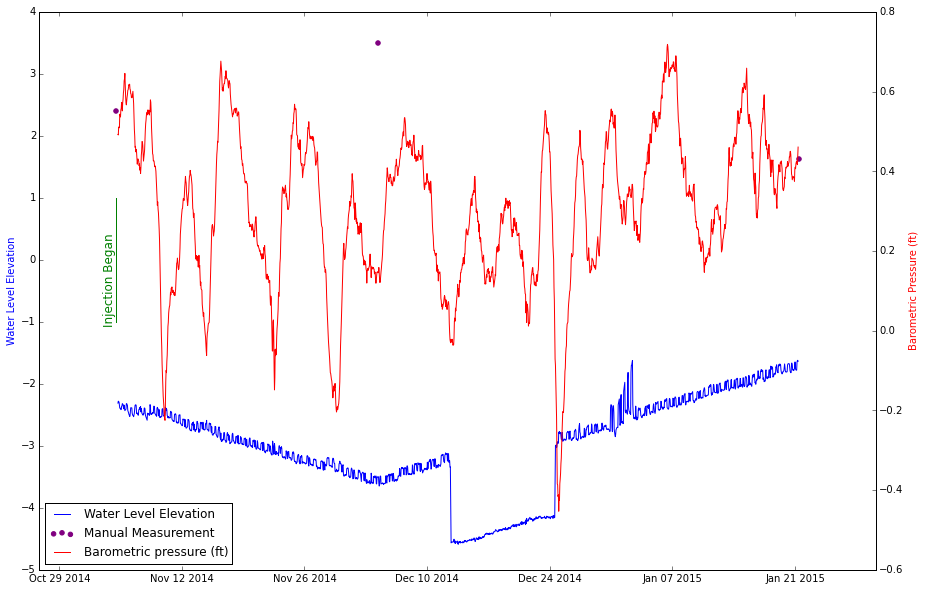

In [50]:
prov_crk_man.loc[:,'WaterElevation'] = prov_crk_man['stg_in']

x1 = prov_crk_man.index.to_datetime()
x2 = prov.index.to_datetime()
y1 = prov_crk_man['stg_in'].values
y2 = prov['WaterElevation'].values

x3 = prov.index.to_datetime()
y3 = prov['abs_feet_above_barologger'].values

fig, ax1 = plt.subplots()
ax1.scatter(x1,y1,color='purple', label='Manual Measurement')
ax1.plot(x2,y2,color='blue',label='Water Level Elevation')
ax1.set_ylabel('Water Level Elevation',color='blue')
y_formatter = tick.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)
ax1.plot(['11/4/2014 11:16','11/4/2014 11:16'],[-1,1], color='green')
ax1.text(x='11/3/2014 1:00',y=0.25,s='Injection Began',rotation=90,color='green',fontsize=12)

ax2 = ax1.twinx()

ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
ax2.plot(x3,y3,color='red',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

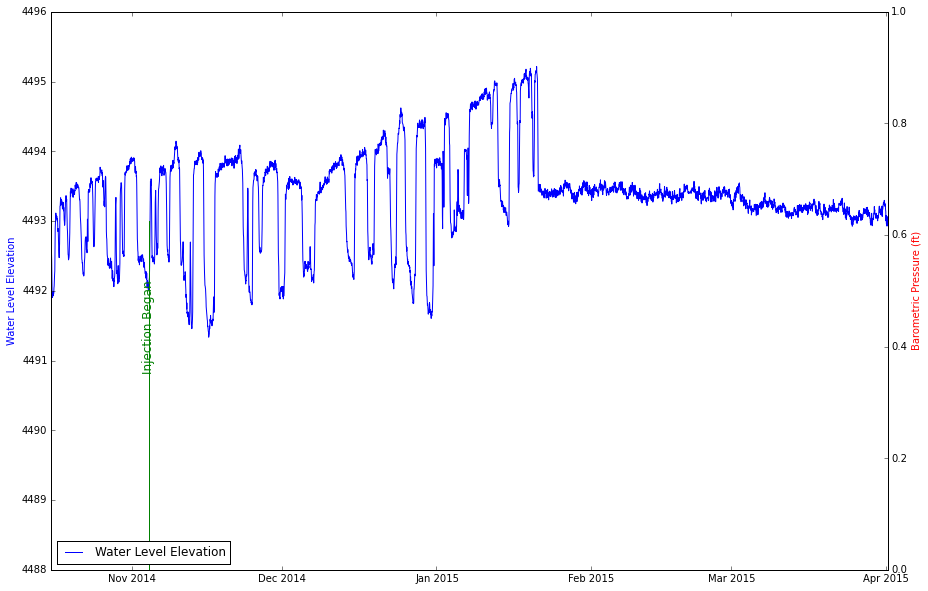

In [53]:
x1 = manualfile.index.to_datetime()
x2 = wellbarofixed.index.to_datetime()
#y1 = manualfile['WaterElevation'].values
y2 = wellbarofixed['WaterElevation'].values

x3 = wellbarofixed.index.to_datetime()
y3 = wellbarofixed['abs_feet_above_barologger'].values

fig, ax1 = plt.subplots()
#ax1.scatter(x1,y1,color='purple', label='Manual Measurement')
ax1.plot(x2,y2,color='blue',label='Water Level Elevation')
ax1.set_ylabel('Water Level Elevation',color='blue')
y_formatter = tick.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)
ax1.plot(['11/4/2014 11:16','11/4/2014 11:16'],[4488,4493], color='green')
ax1.text(x='11/3/2014 1:00',y=4492,s='Injection Began',rotation=90,color='green',fontsize=12)

ax2 = ax1.twinx()

ax2.set_ylabel('Barometric Pressure (ft)', color='red') 
#ax2.plot(x3,y3,color='red',label='Barometric pressure (ft)')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=3)

In [ ]:
wellelevbaro = wellbarofixed.loc[:,('abs_feet_above_barologger','WaterElevation')]

In [ ]:
# clark's method
def clarks(data,bp,wl):
    data['dwl'] = data[wl].diff()
    data['dbp'] = data[bp].diff()
    
    data['beta'] = data['dbp']*data['dwl']
    data['Sbp'] = np.abs(data['dbp']).cumsum()
    data['Swl'] = data[['dwl','beta']].apply(lambda x: -1*np.abs(x[0]) if x[1]>0 else np.abs(x[0]), axis=1).cumsum()
    plt.figure()
    plt.plot(data['Sbp'],data['Swl'])
    regression = ols(y=data['Swl'], x=data['Sbp'])
    
    m = regression.beta.x
    b = regression.beta.intercept
    r = regression.r2
    
    y_reg = [data.ix[i,'Sbp']*m+b for i in range(len(data['Sbp']))]

    plt.plot(data['Sbp'],y_reg,
             label='Regression: Y = {m:.4f}X + {b:.5}\nr^2 = {r:.4f}\n BE = {be:.2f} '.format(m=m,b=b,r=r,be=m))
    plt.legend()
    plt.xlabel('Sum of Barometric Pressure Changes (ft)')
    plt.ylabel('Sum of Water-Level Changes (ft)')
    data.drop(['dwl','dbp','Sbp','Swl'],axis=1,inplace=True)
    return m,b,r

m,b,r = clarks(wellelevbaro, 'abs_feet_above_barologger','WaterElevation')
print m
print b
print r

In [ ]:
def Scat(data,bp,wl):
    data['dwl'] = data[wl].diff()
    data['dbp'] = data[bp].diff()

    regression = ols(y=data['dwl'], x=data['dbp'])
    m = regression.beta.x
    b = regression.beta.intercept
    r = regression.r2
    #r = (regression.beta.r)**2
    plt.scatter(y=data['dwl'], x=data['dbp'])

    y_reg = [data['dbp'][i]*m+b for i in range(len(data['dbp']))]

    plt.plot(data['dbp'],y_reg, 
             label='Regression: Y = {m:.4f}X + {b:.5}\nr^2 = {r:.4f}\n BE = {be:.2f} '.format(m=m,b=b,r=r,be=m))
    plt.legend()
    plt.xlabel('Sum of Barometric Pressure Changes (ft)')
    plt.ylabel('Sum of Water-Level Changes (ft)')
    
Scat(wellelevbaro, 'abs_feet_above_barologger','WaterElevation')

In [ ]:
def baro_eff(df,bp,wl,lag=100):
    df.dropna(inplace=True)
    #dwl = df[wl].diff().values[1:-1]
    #dbp = df[bp].diff().values[1:-1]
    dwl = np.subtract(df[wl].values[1:-1],np.mean(df[wl].values[1:-1]))
    dbp = np.subtract(df[bp].values[1:-1],np.mean(df[bp].values[1:-1]))
    df['j_dates'] = df.index.to_julian_date()
    lag_time = df['j_dates'].diff().cumsum().values[1:-1]
    df.drop('j_dates',axis=1,in_place=True)
    # Calculate BP Response Function

    ## create lag matrix for regression
    bpmat = tools.lagmat(dbp, lag, original='in')
    ## transpose matrix to determine required length
    ## run least squared regression
    sqrd = np.linalg.lstsq(bpmat,dwl)
    wlls = sqrd[0]
    cumls = np.cumsum(wlls)
    negcumls = [-1*cumls[i] for i in range(len(cumls))]
    ymod = np.dot(bpmat,wlls)
    
    ## resid gives the residual of the bp
    resid=[(dwl[i] - ymod[i])+np.mean(df[wl].values[1:-1]) for i in range(len(dwl))]
    lag_trim = lag_time[0:len(cumls)]
    return negcumls, cumls, ymod, resid, lag_time, dwl, dbp



In [ ]:
negcumls, cumls, ymod, resid, lag_time, dwl, dbp = baro_eff(wellelevbaro, 'abs_feet_above_barologger','WaterElevation')
plt.figure()
lag_trim = lag_time[0:len(negcumls)]
plt.plot(lag_trim*24,negcumls, label='b.p. alone')
plt.xlabel('lag (hours)')
plt.ylabel('barometric response')